In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from darts import TimeSeries
from darts.models import NBEATSModel
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import skew, kurtosis
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
df = pd.read_csv("../Data_Sources/clean_data.csv")

In [3]:
df['fecha_llegada'] = pd.to_datetime(df['fecha_llegada'])
df = df[df.fecha_llegada <= '2020-03-28']

In [4]:
df = df[[
    'id_reserva',
    'cantidad_noches',
    'fecha_llegada',
    'habitaciones',
    'cliente_disponible',
    'ingresos_por_habitacion',
    'estatus_de_la_reservacion'
]]

In [5]:
df_ingresos = df[~((df.estatus_de_la_reservacion == "ROOMING LIST") & (df.ingresos_por_habitacion <= 0))]
df_ocupacion = df_ingresos[
    (df_ingresos.estatus_de_la_reservacion != "NO SHOW") |
    (df_ingresos.estatus_de_la_reservacion != "RESERVACION CANCELADA")]
df_ocupacion.drop(columns = ['estatus_de_la_reservacion', 'ingresos_por_habitacion'], inplace = True)
del df_ingresos

In [6]:
estadia_diaria = []

for _, fila in df_ocupacion.iterrows():
    
    for i in range(fila['cantidad_noches']):

        dia = fila['fecha_llegada'] + pd.Timedelta(days = i)    
        estadia_diaria.append({
            'fecha_llegada': dia,
            'id_reserva': fila['id_reserva'],
            'habitaciones': fila['habitaciones'],
            'cliente_disponible': fila['cliente_disponible']
        })
        
df_diario_ocupacion = pd.DataFrame(estadia_diaria)

In [7]:
def get_week_number(date):
    
    date = str(date)
    if isinstance(date, str):
        date = pd.to_datetime(date)

    iso_year, iso_week, _ = date.isocalendar()
    
    return int(f"{iso_year}{iso_week:02d}")

In [8]:
df_diario_ocupacion['anio_semana'] = df_diario_ocupacion['fecha_llegada'].apply(get_week_number)
df_diario_ocupacion.drop('id_reserva', axis = 1, inplace = True)

In [9]:
def get_first_day_week(year_week):
    
    year_week = str(year_week)
    year = int(year_week[:4])
    week = int(year_week[4:])
    
    return dt.date.fromisocalendar(year, week, 1)  # 1 = Monday

def filter_full_weeks(df):
    
    min_semana = df.anio_semana.min()
    max_semana = df.anio_semana.max()
    
    if get_first_day_week(min_semana) not in df.fecha_llegada:
        df = df[df.anio_semana > min_semana]
        
    if get_first_day_week(max_semana) + dt.timedelta(days = 6) not in df.fecha_llegada:
        df = df[df.anio_semana < max_semana]
        
    return df

In [10]:
df_diario_ocupacion = filter_full_weeks(df_diario_ocupacion)

In [11]:
df_grouped_tda_ocupacion = (
    df_diario_ocupacion
    .groupby('fecha_llegada')
    .agg({
        'anio_semana': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        **{col: 'sum' for col in df_diario_ocupacion.select_dtypes(include = 'number').columns if col != 'anio_semana'}
    })
    .sort_index()
    .reset_index()
    .sort_values('fecha_llegada')
)

ts_habitaciones_tda = df_grouped_tda_ocupacion.habitaciones.values
ts_clientes_tda = df_grouped_tda_ocupacion.cliente_disponible.values

In [12]:
from gtda.time_series import SlidingWindow, TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy

def extract_barcode_features(window_size, stride_size, ts, time_delay, embedding_dimension):
    
    sliding_window = SlidingWindow(size = window_size, stride = stride_size)
    ts_windows = sliding_window.fit_transform(ts)
    takens_embedding = TakensEmbedding(time_delay = time_delay, dimension = embedding_dimension)
    ts_embedded = takens_embedding.fit_transform(ts_windows)
    vr = VietorisRipsPersistence(homology_dimensions = [0, 1])
    diagrams = vr.fit_transform(ts_embedded)
    pe = PersistenceEntropy()
    entropies = pe.fit_transform(diagrams)

    barcode_stats_list = []

    for i, diag in enumerate(diagrams):
        
        barcode_stats = {}
        barcode_stats['window'] = i
        mini_diag = diag[diag[:, 2] == 0]
        
        if len(mini_diag) == 0:
            print(f"H0 → No features")
            
        lifespans = mini_diag[:, 1] - mini_diag[:, 0]  # death - birth
        barcode_stats[f'sum_h0_lifespan'] = np.sum(lifespans) if len(lifespans) > 0 else 0
        barcode_stats[f'pe_h0'] = entropies[i][0]
        
        barcode_stats_list.append(barcode_stats)
        
    return barcode_stats_list

In [13]:
window_size = 7
stride_size = 7
time_delay = 1
embedding_dimension = 2

In [14]:
tda_features_habitaciones = extract_barcode_features(window_size = window_size,
                                                     stride_size = stride_size,
                                                     ts = ts_habitaciones_tda,
                                                     time_delay = time_delay,
                                                     embedding_dimension = embedding_dimension)

C:\Users\diego\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\diego\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\diego\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\diego\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
df_grouped_tda_ocupacion_copy = df_grouped_tda_ocupacion.copy()
df_grouped_tda_ocupacion_copy[['sum_h0_lifespan', 'pe_h0']] = np.nan

In [16]:
n_date_stride = 0

for window in range(len(tda_features_habitaciones)):
    
    tda_features_window = tda_features_habitaciones[window]
    
    for date_range in range(window_size):
        df_grouped_tda_ocupacion_copy.loc[date_range + n_date_stride, 'sum_h0_lifespan'] = tda_features_window['sum_h0_lifespan']
        df_grouped_tda_ocupacion_copy.loc[date_range + n_date_stride, 'pe_h0'] = tda_features_window['pe_h0']
        
    n_date_stride += stride_size

In [17]:
df_grouped_tda_ocupacion_model = (
    df_grouped_tda_ocupacion_copy
    .drop('fecha_llegada', axis = 1)
    .groupby('anio_semana')
    .agg({
        'sum_h0_lifespan': lambda x: x.mean() if not x.empty else 0,
        'pe_h0': lambda x: x.mean() if not x.empty else 0,
        'habitaciones': lambda x: x.sum() if not x.empty else 0,
        'cliente_disponible': lambda x: x.sum() if not x.empty else 0
    })
    .sort_index()
    .reset_index()
    .sort_values('anio_semana')
)

In [18]:
df_grouped_tda_ocupacion_model = df_grouped_tda_ocupacion_model.iloc[:-1]

In [19]:
ts_habitaciones = df_grouped_tda_ocupacion_model.habitaciones
ts_clientes = df_grouped_tda_ocupacion_model.cliente_disponible

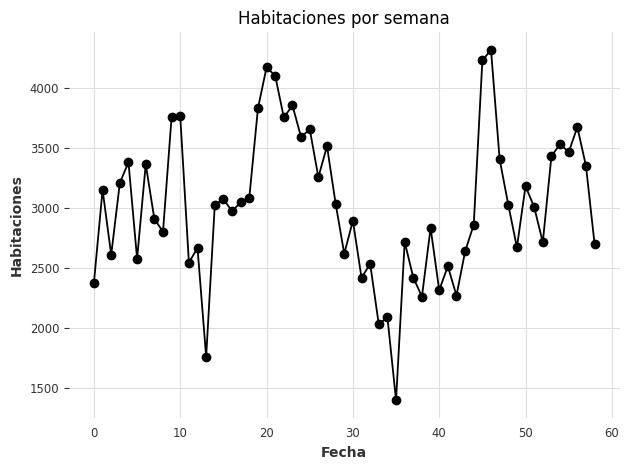

In [20]:
plt.plot(df_grouped_tda_ocupacion_model['habitaciones'], marker='o', linestyle='-')
plt.title('Habitaciones por semana')
plt.xlabel('Fecha')
plt.ylabel('Habitaciones')
plt.grid(True)
plt.tight_layout()
plt.show()

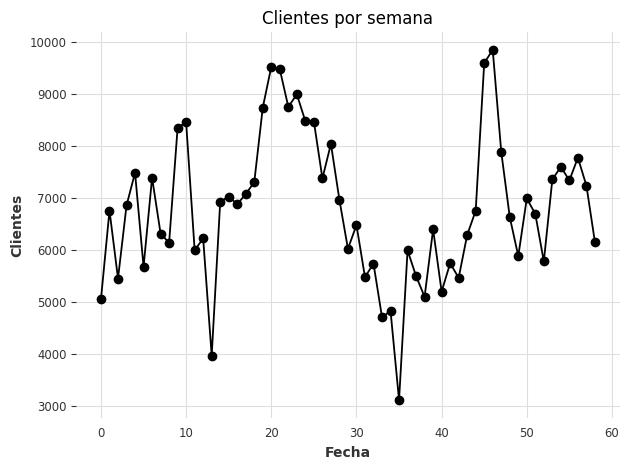

In [21]:
plt.plot(df_grouped_tda_ocupacion_model['cliente_disponible'], marker='o', linestyle='-')
plt.title('Clientes por semana')
plt.xlabel('Fecha')
plt.ylabel('Clientes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_grouped_tda_ocupacion_model.to_csv("../Data_Sources/model_ready_data.csv")

## Desarrollo de los datos para entrenamiento

In [23]:
def evaluate_forecast(y_true, y_pred, verbose = True):
    
    residuals = y_true - y_pred
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    lb_test = acorr_ljungbox(residuals, lags = [1], return_df=True)
    ljung_box_Q = lb_test['lb_stat'].iloc[0]
    ljung_box_p = lb_test['lb_pvalue'].iloc[0]
    jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
    X = sm.add_constant(np.arange(len(residuals)))
    model = sm.OLS(residuals, X).fit()
    het_stat, het_pvalue, _, _ = het_breuschpagan(residuals, model.model.exog)
    res_skew = skew(residuals)
    res_kurtosis = kurtosis(residuals, fisher=False)

    if verbose:
        print(f"Ljung-Box (L1) (Q):        {ljung_box_Q:.2f}   Prob(Q):            {ljung_box_p:.2f}")
        print(f"Jarque-Bera (JB):         {jb_stat:.2f}   Prob(JB):           {jb_pvalue:.2f}")
        print(f"Heteroskedasticity (H):   {het_stat:.2f}   Prob(H):           {het_pvalue:.2f}")
        print(f"Skew:                     {res_skew:.2f}   Kurtosis:          {res_kurtosis:.2f}")
        print(f"\nRMSE: {rmse:.3f}")
        print(f"MAE:  {mae:.3f}")
        print(f"R² Score: {r2:.3f}")

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Ljung-Box Q': ljung_box_Q,
        'Ljung-Box p': ljung_box_p,
        'JB Stat': jb_stat,
        'JB p': jb_pvalue,
        'Heteroskedasticity Stat': het_stat,
        'Heteroskedasticity p': het_pvalue,
        'Skew': res_skew,
        'Kurtosis': res_kurtosis
    }


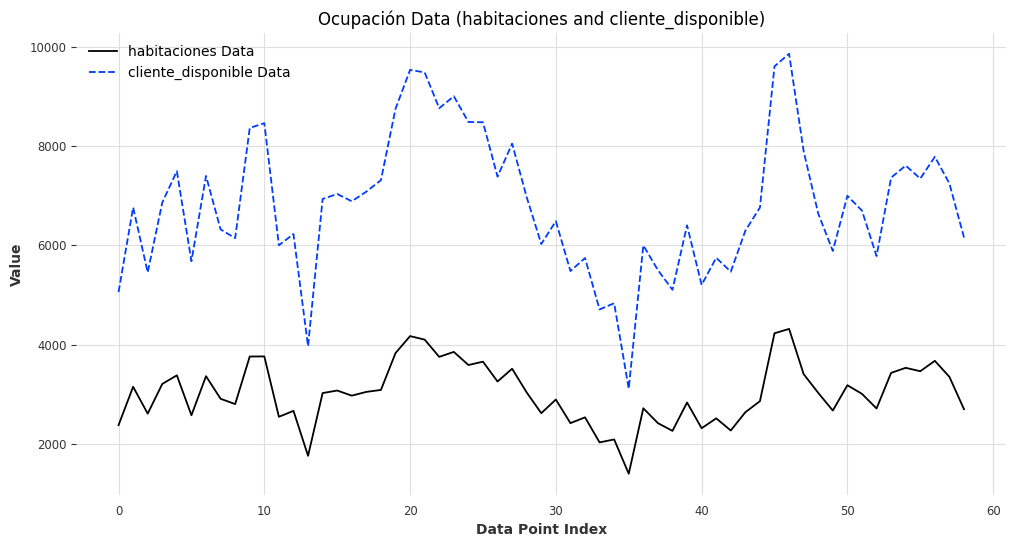

Training data size: 47
Testing data size: 12
Training exogenous data size: 47
Testing exogenous data size: 12


In [24]:
data = df_grouped_tda_ocupacion_model['habitaciones']
exog_data = df_grouped_tda_ocupacion_model[['cliente_disponible', 'sum_h0_lifespan', 'pe_h0']]
# exog_data = df_grouped_tda_ocupacion_model[['cliente_disponible']]

plt.figure(figsize=(12, 6))
plt.plot(data, label = 'habitaciones Data')
plt.plot(exog_data['cliente_disponible'], label = 'cliente_disponible Data', linestyle = '--')
plt.title('Ocupación Data (habitaciones and cliente_disponible)')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:]
train_exog, test_exog = exog_data[0:train_size], exog_data[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")
print(f"Training exogenous data size: {len(train_exog)}")
print(f"Testing exogenous data size: {len(test_exog)}")

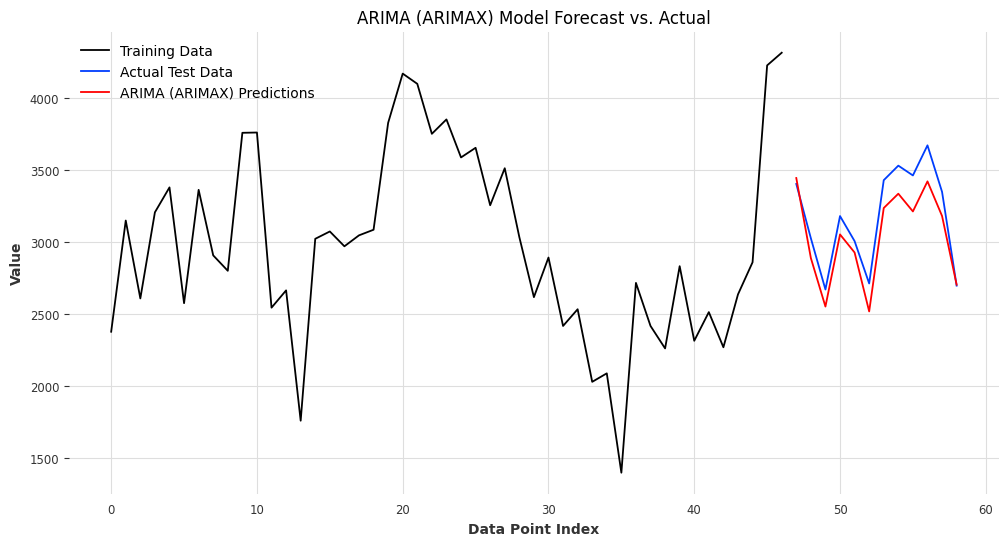

In [25]:
order_arima = (1, 1, 1)
model_arima = ARIMA(train_data, order = order_arima, exog = train_exog, trend = 'n')
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(
    start=train_data.index[-1] + 1,
    end=data.index[-1],
    exog=test_exog)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label = 'Training Data')
plt.plot(test_data.index, test_data, label = 'Actual Test Data')
plt.plot(predictions_arima.index, predictions_arima, color = 'red', label = 'ARIMA (ARIMAX) Predictions')
plt.title(f'ARIMA (ARIMAX) Model Forecast vs. Actual')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
evaluate_forecast(test_data, predictions_arima)

Ljung-Box (L1) (Q):        0.83   Prob(Q):            0.36
Jarque-Bera (JB):         1.11   Prob(JB):           0.57
Heteroskedasticity (H):   2.23   Prob(H):           0.14
Skew:                     -0.72   Kurtosis:          2.59

RMSE: 164.138
MAE:  146.674
R² Score: 0.760


{'RMSE': 164.13788769304645,
 'MAE': 146.67431457039118,
 'R2': 0.7604171355313024,
 'Ljung-Box Q': 0.8328945919273568,
 'Ljung-Box p': 0.3614368608412417,
 'JB Stat': 1.1145452699045515,
 'JB p': 0.5727690858922758,
 'Heteroskedasticity Stat': 2.2301382434578847,
 'Heteroskedasticity p': 0.13534173774808336,
 'Skew': -0.7176178051603407,
 'Kurtosis': 2.5886737515347162}

### NBEATS

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

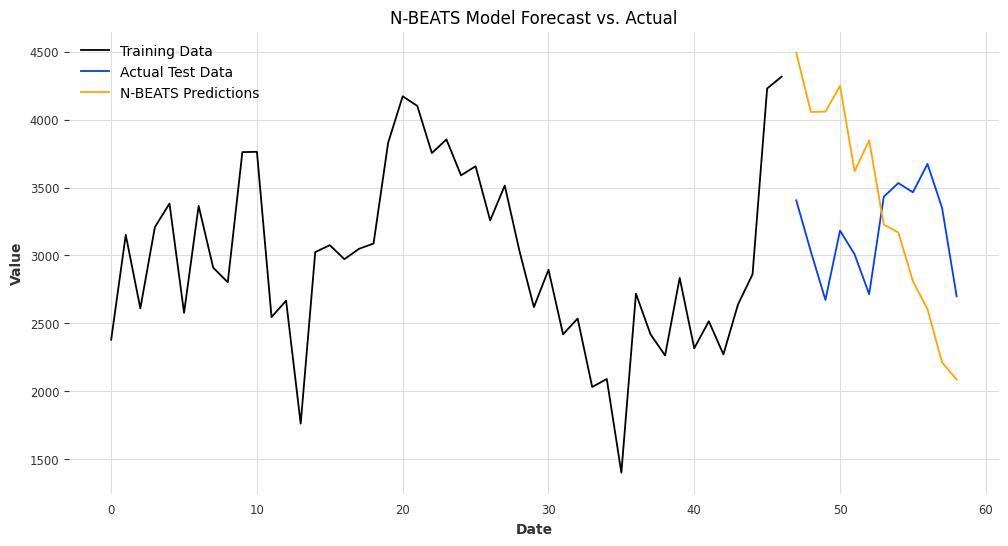

In [27]:
series = TimeSeries.from_series(data)
exog_series = TimeSeries.from_dataframe(exog_data, time_col = None)
train_series = series[:train_size]
test_series = series[train_size:]
train_exog_series = exog_series[:train_size]
test_exog_series = exog_series[train_size:]
model_nbeats = NBEATSModel(
    input_chunk_length = 12,
    output_chunk_length = len(test_data),
    n_epochs = 50,
    random_state = 42,
    force_reset = True)
model_nbeats.fit(
    series = train_series,
    past_covariates = train_exog_series,
    verbose = False)
predictions_nbeats_series = model_nbeats.predict(
    n = len(test_data),
    past_covariates = exog_series)
predictions_nbeats = pd.Series(predictions_nbeats_series.values().flatten(), index = test_data.index)

plt.figure(figsize = (12, 6))
plt.plot(train_data.index, train_data, label = 'Training Data')
plt.plot(test_data.index, test_data, label ='Actual Test Data')
plt.plot(predictions_nbeats.index, predictions_nbeats, color = 'orange', label = 'N-BEATS Predictions')
plt.title(f'N-BEATS Model Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
evaluate_forecast(predictions_nbeats, test_data)

Ljung-Box (L1) (Q):        9.12   Prob(Q):            0.00
Jarque-Bera (JB):         1.36   Prob(JB):           0.51
Heteroskedasticity (H):   1.79   Prob(H):           0.18
Skew:                     -0.12   Kurtosis:          1.37

RMSE: 929.318
MAE:  862.586
R² Score: -0.437


{'RMSE': 929.3180737653955,
 'MAE': 862.5859909485516,
 'R2': -0.43711178396963435,
 'Ljung-Box Q': 9.124411306749295,
 'Ljung-Box p': 0.0025222103449101287,
 'JB Stat': 1.3596494096600886,
 'JB p': 0.5067058076615875,
 'Heteroskedasticity Stat': 1.7948599535939782,
 'Heteroskedasticity p': 0.18033514563367906,
 'Skew': -0.11647867196762304,
 'Kurtosis': 1.3675081331820325}

### SARIMAX

c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


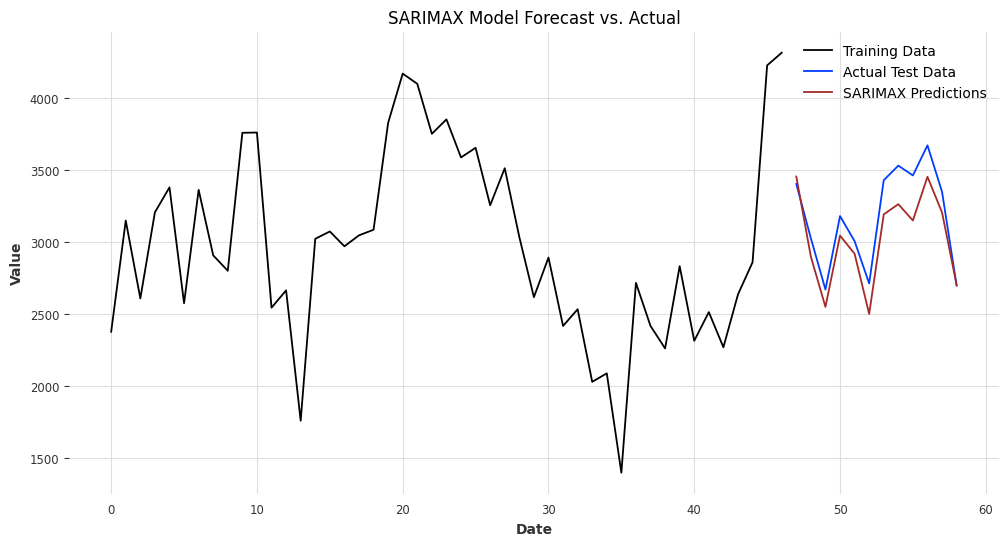

In [29]:
seasonal_period = 52
order_sarimax = (1, 0, 0)
seasonal_order_sarimax = (1, 0, 0, seasonal_period)
model_sarimax = SARIMAX(
    train_data,
    order = order_sarimax,
    seasonal_order = seasonal_order_sarimax,
    exog = train_exog,
    trend = 'n').fit()
predictions_sarimax = model_sarimax.predict(
    start = test_data.index[0],
    end = test_data.index[-1],
    exog = test_exog)

plt.figure(figsize = (12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(predictions_sarimax.index, predictions_sarimax, color='brown', label='SARIMAX Predictions')
plt.title(f'SARIMAX Model Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
evaluate_forecast(test_data, predictions_sarimax)

Ljung-Box (L1) (Q):        2.29   Prob(Q):            0.13
Jarque-Bera (JB):         0.48   Prob(JB):           0.79
Heteroskedasticity (H):   1.45   Prob(H):           0.23
Skew:                     -0.40   Kurtosis:          2.43

RMSE: 182.201
MAE:  159.829
R² Score: 0.705


{'RMSE': 182.20146993513097,
 'MAE': 159.82942681804613,
 'R2': 0.7047826853227188,
 'Ljung-Box Q': 2.2887750316733806,
 'Ljung-Box p': 0.13031273441360786,
 'JB Stat': 0.48141179402442075,
 'JB p': 0.7860727787482295,
 'Heteroskedasticity Stat': 1.447841618108809,
 'Heteroskedasticity p': 0.2288745991155306,
 'Skew': -0.3985843773575324,
 'Kurtosis': 2.4278587896726243}

### Regresor multivariado

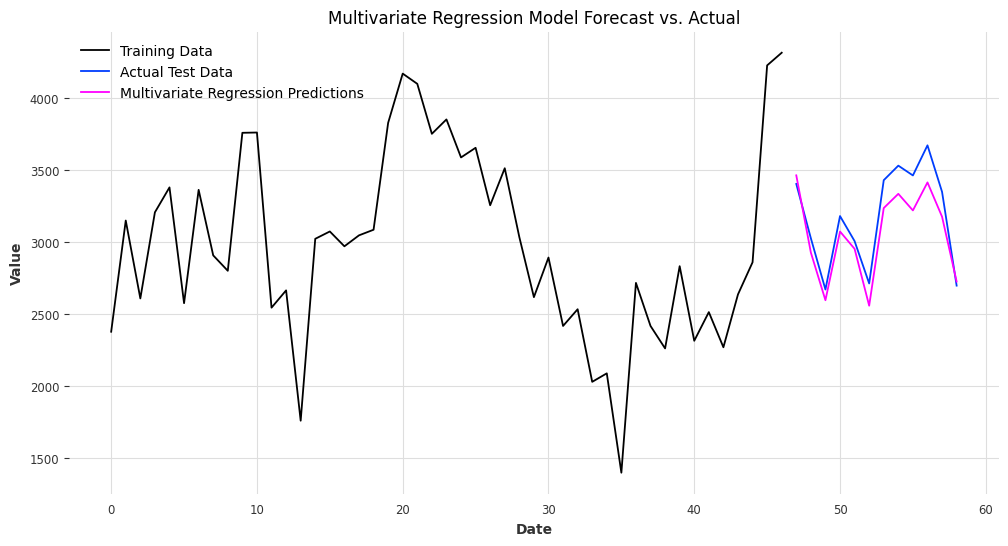

In [31]:
X_train_reg = train_exog
X_test_reg = test_exog
y_train_reg = train_data
y_test_reg = test_data
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)
predictions_reg = model_reg.predict(X_test_reg)
predictions_reg = pd.Series(predictions_reg, index = y_test_reg.index)

plt.figure(figsize = (12, 6))
plt.plot(y_train_reg.index, y_train_reg, label = 'Training Data')
plt.plot(y_test_reg.index, y_test_reg, label = 'Actual Test Data')
plt.plot(predictions_reg.index, predictions_reg, color = 'magenta', label = 'Multivariate Regression Predictions')
plt.title(f'Multivariate Regression Model Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
evaluate_forecast(predictions_reg, y_test_reg)

Ljung-Box (L1) (Q):        1.70   Prob(Q):            0.19
Jarque-Bera (JB):         0.70   Prob(JB):           0.71
Heteroskedasticity (H):   3.29   Prob(H):           0.07
Skew:                     0.44   Kurtosis:          2.21

RMSE: 155.132
MAE:  136.600
R² Score: 0.723


{'RMSE': 155.13241649753374,
 'MAE': 136.60039005070772,
 'R2': 0.7226209358243195,
 'Ljung-Box Q': 1.6975327319576898,
 'Ljung-Box p': 0.19261095830249175,
 'JB Stat': 0.6984275782129334,
 'JB p': 0.7052423410220499,
 'Heteroskedasticity Stat': 3.2878257764397376,
 'Heteroskedasticity p': 0.06979538770974088,
 'Skew': 0.43728790433416875,
 'Kurtosis': 2.2050331382265105}

### Prophet

Prophet Training data size: 47
Prophet Testing data size: 12


01:06:25 - cmdstanpy - INFO - Chain [1] start processing
01:06:25 - cmdstanpy - INFO - Chain [1] done processing


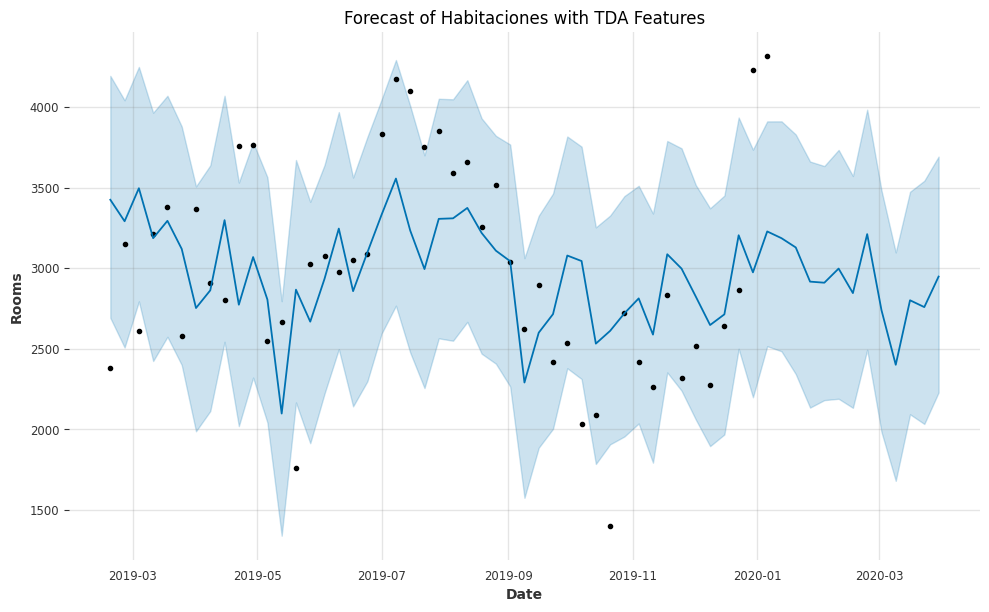

In [33]:
df_prophet = df_grouped_tda_ocupacion_model.copy()
df_prophet['ds'] = pd.to_datetime(df_prophet['anio_semana'].astype(str) + '-1', format = '%Y%W-%w')
df_prophet.rename(columns = {'habitaciones': 'y'}, inplace = True) # Prophet requires target column to be named 'y'
df_prophet.sort_values(by = 'ds', inplace = True)
train_size = int(len(df_prophet) * 0.8)
train_prophet_df = df_prophet.iloc[0:train_size].copy()
test_prophet_df = df_prophet.iloc[train_size:].copy()

print(f"Prophet Training data size: {len(train_prophet_df)}")
print(f"Prophet Testing data size: {len(test_prophet_df)}")

model_tda = Prophet(
    yearly_seasonality = False,
    weekly_seasonality = True,
    daily_seasonality = False)
model_tda.add_regressor('sum_h0_lifespan')
model_tda.add_regressor('pe_h0')
model_tda.fit(train_prophet_df[['ds', 'y', 'sum_h0_lifespan', 'pe_h0']])
future_tda = model_tda.make_future_dataframe(periods = len(test_prophet_df), freq = 'W-MON')
future_tda = future_tda.merge(df_prophet[['ds', 'sum_h0_lifespan', 'pe_h0']], on = 'ds', how = 'left')
forecast_tda = model_tda.predict(future_tda)
forecast_test = forecast_tda[forecast_tda['ds'].isin(test_prophet_df['ds'])]
y_true = test_prophet_df.sort_values('ds')['y'].values
y_pred = forecast_test.sort_values('ds')['yhat'].values
model_tda.plot(forecast_tda)

plt.title("Forecast of Habitaciones with TDA Features")
plt.xlabel("Date")
plt.ylabel("Rooms")
plt.show()
plt.show()

In [34]:
evaluate_forecast(y_true, y_pred)

Ljung-Box (L1) (Q):        4.41   Prob(Q):            0.04
Jarque-Bera (JB):         1.07   Prob(JB):           0.59
Heteroskedasticity (H):   3.18   Prob(H):           0.07
Skew:                     0.45   Kurtosis:          1.84

RMSE: 516.251
MAE:  397.633
R² Score: -1.370


{'RMSE': 516.2513289636222,
 'MAE': 397.6325078935276,
 'R2': -1.3700659888650941,
 'Ljung-Box Q': 4.4076395472915655,
 'Ljung-Box p': 0.03577831559985185,
 'JB Stat': 1.068139867252782,
 'JB p': 0.5862142548450002,
 'Heteroskedasticity Stat': 3.1841985263970467,
 'Heteroskedasticity p': 0.07435345131076393,
 'Skew': 0.4467279421994363,
 'Kurtosis': 1.843273447551846}

In [35]:
df_xgb = df_grouped_tda_ocupacion_model.copy()
features = ['cliente_disponible']
tda = ['sum_h0_lifespan', 'pe_h0']
features += tda

for lag in range(1, 7):
    df_xgb[f'lag_{lag}'] = df_xgb['habitaciones'].shift(lag)
    features += [f'lag_{lag}']
    
df_xgb['rolling_mean_7'] = df_xgb['habitaciones'].shift(1).rolling(window = 7).mean()
df_xgb = df_xgb.dropna()
features += ['rolling_mean_7']
split_index = int(len(df_xgb) * 0.7)
train = df_xgb.iloc[:split_index]
test = df_xgb.iloc[split_index:]
features = [col for col in df_xgb.columns if col in features]
X = df_xgb[features].values
y = df_xgb['habitaciones'].values
train_sizes = []
train_errors = []
test_errors = []
X_train = train[features]
y_train = train['habitaciones']
X_test = test[features]
y_test = test['habitaciones']

Fitting 5 folds for each of 162 candidates, totalling 810 fits


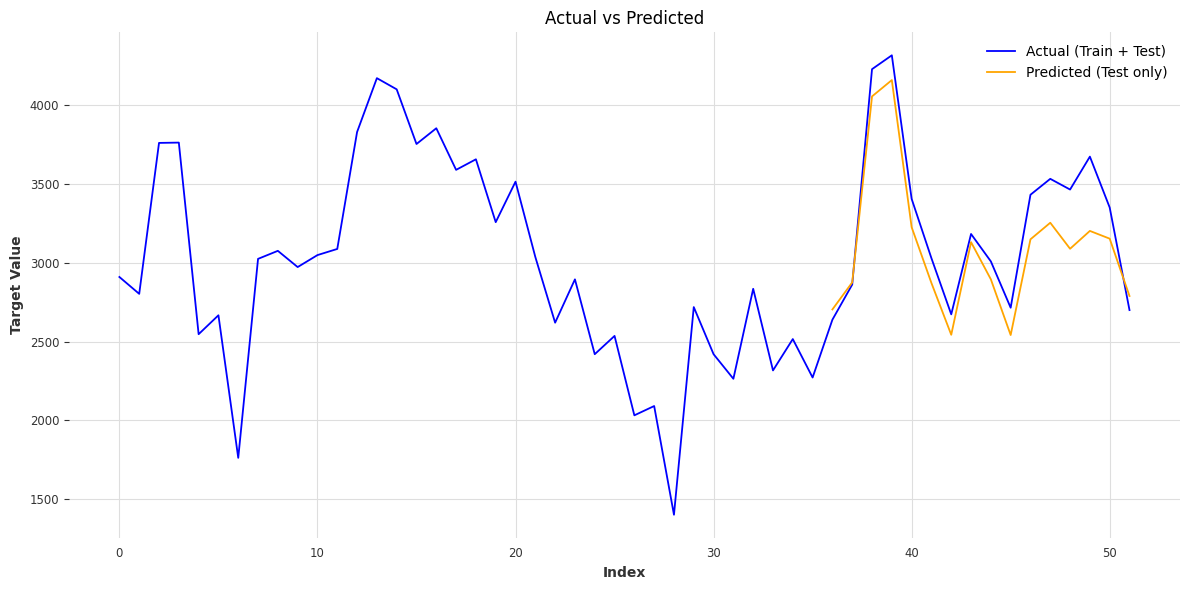

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

cv_strategy = KFold(n_splits = 5, shuffle = True, random_state = 42)
xgb_base = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42)
scoring = {'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'}
refit_metric = 'neg_mae'
grid_search = GridSearchCV(
    estimator = xgb_base,
    param_grid = param_grid,
    cv = cv_strategy,
    scoring = scoring, 
    refit = refit_metric,
    verbose = 1,
    n_jobs = -1)
grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
best_r2_cv = grid_search.cv_results_['mean_test_r2'][best_index]
best_xgb_model_grid = grid_search.best_estimator_
y_pred_grid = best_xgb_model_grid.predict(X_test)
actual_all = np.concatenate([y_train, y_test])
pred_line = np.concatenate([np.full(len(y_train), np.nan), y_pred_grid])

plt.figure(figsize=(12, 6))
plt.plot(actual_all, label='Actual (Train + Test)', color='blue')
plt.plot(pred_line, label='Predicted (Test only)', color='orange')
plt.xlabel("Index")
plt.ylabel("Target Value")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
evaluate_forecast(y_test, y_pred_grid)

Ljung-Box (L1) (Q):        4.19   Prob(Q):            0.04
Jarque-Bera (JB):         0.13   Prob(JB):           0.94
Heteroskedasticity (H):   4.24   Prob(H):           0.04
Skew:                     0.20   Kurtosis:          2.81

RMSE: 216.067
MAE:  181.908
R² Score: 0.814


{'RMSE': 216.0670107281535,
 'MAE': 181.90818786621094,
 'R2': 0.8144047260284424,
 'Ljung-Box Q': 4.190241826083165,
 'Ljung-Box p': 0.040657297289335405,
 'JB Stat': 0.12668302227401468,
 'JB p': 0.9386228687840369,
 'Heteroskedasticity Stat': 4.235012277970187,
 'Heteroskedasticity p': 0.039598337177726636,
 'Skew': 0.19717370582086313,
 'Kurtosis': 2.8142188051968313}